# 1. Importación de librerías y carga de datos

In [1]:
!pip install codecarbon

In [2]:
#from google.colab import drive

import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import random
import scipy
import time
import os

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.keras.backend.set_floatx('float64')

In [4]:
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/MyDrive

In [5]:
#DATASETS_FOLDER = os.path.join("TFM", "implementation", "datasets")
#POSITIONS_FILE = os.path.join(DATASETS_FOLDER, "positions.csv")
df = pd.read_csv('positions.csv')

columns = ['time(s)', 'vehicle_id', 'latitude(m)', 'longitude(m)', 'heading']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])
df.head()

,time(s),vehicle_id,latitude(m),longitude(m),heading
1063,11.0,2,41.391721,2.162130,43.871783
1168,12.0,2,41.391790,2.162216,43.871783
1273,13.0,2,41.391775,2.162315,124.611142
1378,14.0,2,41.391727,2.162396,131.690664
1483,15.0,2,41.391681,2.162464,133.978174


In [6]:
# Load fitted model
MODEL_FOLDER = './simple/GRU_32units/'#os.path.join("TFM", "implementation", "models", "scaled",
                            #"simple", "LSTM_64units")
MODEL_FILE = MODEL_FOLDER + "model_saved.hdf5"#os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

In [7]:
# Load testing data
DATASET_TEST = "./ventanas_no_coincidentes_test_scaled.npz"#os.path.join(DATASETS_FOLDER,
                            #"ventanas_no_coincidentes_test_scaled.npz")

npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = './vehicle_ids.pkl'#os.path.join(DATASETS_FOLDER, "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_test: (3001, 20, 3)  y_test: (3001, 5, 3)
Vehicle_ids: 3001


In [8]:
# Load MinMaxScaler for target variables
MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation","data_preparation", "minmaxscaler.pkl")
with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
    minmaxscaler = pickle.load(f_minmaxscaler)

In [9]:
# Load dataset with vehicles dimensions
DATASET_DIM = './dimensions.csv'#os.path.join(DATASETS_FOLDER, "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,2,5.0,1.8
1,3,5.0,1.8
2,4,2.2,0.9
3,5,5.0,1.8
4,6,5.0,1.8


In [12]:
# Load dataset with vehicles colision
DATASET_COL = './collisions_1k.csv'#os.path.join(DATASETS_FOLDER, "collisions_1k.csv")
df_col = pd.read_csv(DATASET_COL, delimiter=';')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,121,103
1,158,113
2,197,165
3,193,230
4,207,122


In [13]:
# Load dataset with vehicles no-colision
DATASET_NOCOL = './no_collisions_1k.csv'#os.path.join(DATASETS_FOLDER, "no_collisions_1k.csv")
df_nocol = pd.read_csv(DATASET_NOCOL, delimiter=';')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,800,770
1,4115,4132
2,2054,2006
3,736,782
4,1291,1262


# 2. Cálculo de la probabilidad de colisión

In [14]:
# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points


def get_collision(v1_id, v2_id, v1_coords, v2_coords, dimensions):
    colision = 0

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]
    v1_points = get_rotated_points(tuple(v1_coords[:2]), v1_coords[2],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]
    v2_points = get_rotated_points(tuple(v2_coords[:2]), v2_coords[2],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision


def calculate_variance(values):
    # Calculate the mean of the values
    mean = np.mean(values)

    # Calculate the variance by summing the squared differences
    # between each value and the mean, and dividing by the number of values
    variance = np.sum((values - mean) ** 2) / len(values)

    return variance


def calculate_covariance(values1, values2):
    # Calculate the means of the values
    mean1 = np.mean(values1)
    mean2 = np.mean(values2)

    # Calculate the covariance by summing the products of the differences
    # between each pair of values and the means, and dividing by the number of values
    covariance = np.sum((values1 - mean1) * (values2 - mean2)) / len(values1)

    return covariance


def calculate_covariance_matrix(latitudes, longitudes, thetas):
    # Calculate the variance of the coordinates and orientation
    # var_lat = calculate_variance(latitudes) # or np.var(latitudes)
    # var_long = calculate_variance(longitudes) # or np.var(longitudes)
    # var_theta = calculate_variance(thetas)  # or np.var(thetas)
    var_lat = np.var(latitudes)
    var_long = np.var(longitudes)
    var_theta = np.var(thetas)

    # Calculate the covariance between the coordinates and orientation
    cov_latlong = calculate_covariance(latitudes, longitudes)
    cov_lattheta = calculate_covariance(latitudes, thetas)
    cov_longtheta = calculate_covariance(longitudes, thetas)

    # Return the covariance matrix
    return np.array([[var_lat, cov_latlong, cov_lattheta],
                     [cov_latlong, var_long, cov_longtheta],
                     [cov_lattheta, cov_longtheta, var_theta]])


def calculate_pdf(y_pred):
    # Calculate the mean position of the vehicle based on its coordinates and orientation
    mean = [np.mean(y_pred[:, 0]), np.mean(y_pred[:, 1]), np.mean(y_pred[:, 2])]

    # Calculate the covariance matrix of the vehicle's position based on its coordinates and orientation
    covariance = calculate_covariance_matrix(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])

    # Return the probability density function for the vehicle
    return scipy.stats.multivariate_normal(mean=mean, cov=covariance,
                                           allow_singular=True)


def collision_probability(y_pred1, y_pred2, num_samples=1000):
    # Calculate the probability density function for both vehicles
    pdf1 = calculate_pdf(y_pred1)
    pdf2 = calculate_pdf(y_pred2)

    # Generate random samples for the positions of both vehicles
    samples1 = pdf1.rvs(size=num_samples)
    samples2 = pdf2.rvs(size=num_samples)

    # Calculate the number of samples where the vehicles are closer
    collisions = 0
    for i in range(num_samples):
    # Check if there is collision between the vehicles
        if get_collision(v1_id, v2_id, samples1[i], samples2[i], df_dim):
            collisions += 1

    # Return the fraction of samples where the vehicles collide
    return collisions / num_samples

## 2.1. Análisis de tiempos

In [15]:
# We use the same vehicles for all tests
v1_id = df_col.iloc[0, 0]
v2_id = df_col.iloc[0, 1]

y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

### 2.1.1. 100 muestras

In [16]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=100)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  0.5245966911315918
Emissions (kg):  2.5046067390455324e-06
Collision probability:  0.01


### 2.1.2. 250 muestras

In [17]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=250)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  1.021268606185913
Emissions (kg):  3.6460694746740016e-06
Collision probability:  0.032


### 2.1.3 300 muestras

In [18]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=300)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  1.5777819156646729
Emissions (kg):  4.691291615229949e-06
Collision probability:  0.03


### 2.1.3 350 muestras

In [19]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=350)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  1.3813047409057617
Emissions (kg):  4.309076937814882e-06
Collision probability:  0.03142857142857143


### 2.1.4. 500 muestras

In [20]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=500)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  2.1432676315307617
Emissions (kg):  5.737831179904913e-06
Collision probability:  0.024


### 2.1.5. 1000 muestras

In [21]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=1000)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  4.062134265899658
Emissions (kg):  9.285928891335933e-06
Collision probability:  0.028


## 2.2. Probabilidad de colisión en el conjunto de datos real

In [22]:
PREDICT=False
SAMPLES=300

col_array = np.empty((0, 5))

# Vehiculos que coinciden y colisionan
for i in range(df_col.shape[0]):
    v1_id = df_col.iloc[i, 0]
    v2_id = df_col.iloc[i, 1]

    if PREDICT:
        v1_index = vehicle_ids.index(v1_id)
        y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
        y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
        y_v1 = y_v1.reshape(-1, 3)

        v2_index = vehicle_ids.index(v2_id)
        y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
        y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
        y_v2 = y_v2.reshape(-1, 3)
    else:
        y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
        y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Vehiculos que coinciden pero no colisionan
for i in range(df_nocol.shape[0]):
    v1_id = df_nocol.iloc[i, 0]
    v2_id = df_nocol.iloc[i, 1]

    if PREDICT:
        v1_index = vehicle_ids.index(v1_id)
        y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
        y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
        y_v1 = y_v1.reshape(-1, 3)

        v2_index = vehicle_ids.index(v2_id)
        y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
        y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
        y_v2 = y_v2.reshape(-1, 3)
    else:
        y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
        y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

In [24]:
DATASETS_FOLDER = './'
if PREDICT:
    PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob.csv")
else:
    PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob.csv")

df_collision_prob = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob.to_csv(PROB_FILE, index=False)
df_collision_prob.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,121.0,103.0,1.203780,0.033333,1.0
1,158.0,113.0,1.339417,0.013333,1.0
2,197.0,165.0,1.268607,0.736667,1.0
3,193.0,230.0,1.156906,0.023333,1.0
4,207.0,122.0,1.272596,0.003333,1.0


In [25]:
df_collision_prob[df_collision_prob['collision'] == 0].head()

,vehicle1,vehicle2,execution_time,probability,collision
1000,800.0,770.0,1.247663,0.000000,0.0
1001,4115.0,4132.0,1.245668,0.646667,0.0
1002,2054.0,2006.0,1.168873,0.006667,0.0
1003,736.0,782.0,1.146933,0.000000,0.0
1004,1291.0,1262.0,1.131973,0.000000,0.0


In [26]:
collisions = df_collision_prob[df_collision_prob['collision'] == 1]
no_collisions = df_collision_prob[df_collision_prob['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.0834700000000001
Probabilidad media de colision para las no-colisiones: 0.06999666666666668
Tiempo medio de ejecuion para las colisiones: 1.1573280193805695
Tiempo medio de ejecuion para las no-colisiones: 1.1423223152160644


In [27]:
collisions['probability'].describe()

count    1000.000000
mean        0.083470
std         0.105927
min         0.000000
25%         0.016667
50%         0.046667
75%         0.116667
max         0.966667
Name: probability, dtype: float64

In [28]:
no_collisions['probability'].describe()

count    1000.000000
mean        0.069997
std         0.111321
min         0.000000
25%         0.000000
50%         0.023333
75%         0.083333
max         0.746667
Name: probability, dtype: float64

In [29]:
collision_threshold = 0.016

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 769
Valores por debajo de la media en las colisiones: 231
Valores por encima de la media en las no-colisiones: 571
Valores por debajo de la media en las no-colisiones: 429


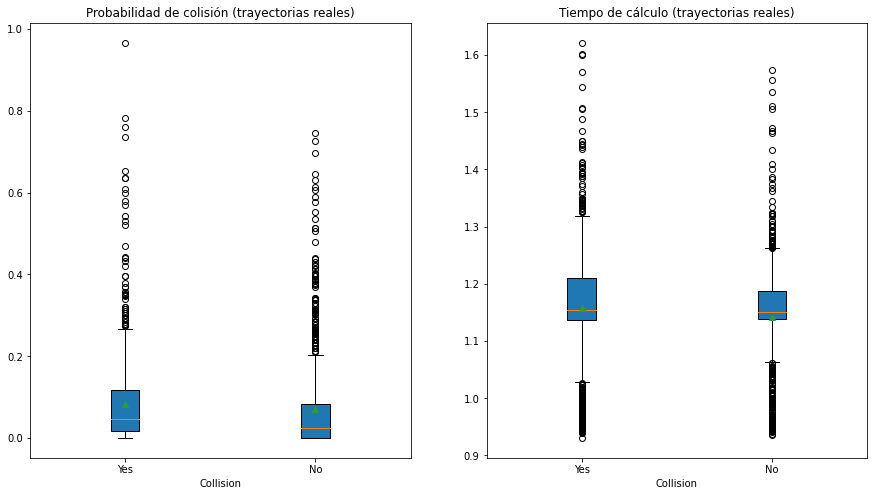

In [30]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Probabilidad de colisión (trayectorias reales)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Tiempo de cálculo (trayectorias reales)")
ax[1].set_xlabel("Collision")
plt.show()

## 2.3. Probabilidad de colisión en el conjunto de datos predicho

In [31]:
PREDICT=True
SAMPLES=300

col_array = np.empty((0, 5))

# Vehiculos que coinciden y colisionan
for i in range(df_col.shape[0]):
    v1_id = df_col.iloc[i, 0]
    v2_id = df_col.iloc[i, 1]

    if PREDICT:
        v1_index = vehicle_ids.index(v1_id)
        y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
        y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
        y_v1 = y_v1.reshape(-1, 3)

        v2_index = vehicle_ids.index(v2_id)
        y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
        y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
        y_v2 = y_v2.reshape(-1, 3)
    else:
        y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
        y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Vehiculos que coinciden pero no colisionan
for i in range(df_nocol.shape[0]):
    v1_id = df_nocol.iloc[i, 0]
    v2_id = df_nocol.iloc[i, 1]

    if PREDICT:
        v1_index = vehicle_ids.index(v1_id)
        y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
        y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
        y_v1 = y_v1.reshape(-1, 3)

        v2_index = vehicle_ids.index(v2_id)
        y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
        y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
        y_v2 = y_v2.reshape(-1, 3)
    else:
        y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
        y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

In [32]:
if PREDICT:
    PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob.csv")
else:
    PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob.csv")

df_collision_prob = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob.to_csv(PROB_FILE, index=False)
df_collision_prob.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,121.0,103.0,1.007307,0.010000,1.0
1,158.0,113.0,1.213754,0.000000,1.0
2,197.0,165.0,1.322462,0.116667,1.0
3,193.0,230.0,1.356372,0.000000,1.0
4,207.0,122.0,1.480042,0.000000,1.0


In [33]:
collisions = df_collision_prob[df_collision_prob['collision'] == 1]
no_collisions = df_collision_prob[df_collision_prob['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.015543333333333343
Probabilidad media de colision para las no-colisiones: 0.029423333333333353
Tiempo medio de ejecuion para las colisiones: 1.1846556453704833
Tiempo medio de ejecuion para las no-colisiones: 1.7456601045131683


In [34]:
collision_threshold = 0.016

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 142
Valores por debajo de la media en las colisiones: 858
Valores por encima de la media en las no-colisiones: 147
Valores por debajo de la media en las no-colisiones: 853


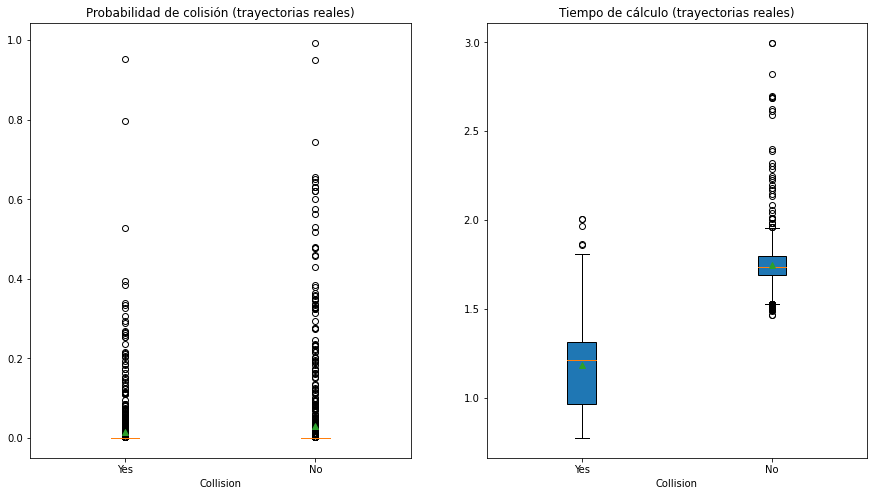

In [35]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Probabilidad de colisión (trayectorias reales)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Tiempo de cálculo (trayectorias reales)")
ax[1].set_xlabel("Collision")
plt.show()